# Project 1

## **Research Question:** *Quantifying public engagement toward political parties on twitter to predict election results*

### Introduction 
##### Social media platforms like Facebook and Twitter have entirely altered how we share news and opinions regarding current affairs. Twitter is an integral part of the mainstream media and has allowed it to become a platform for electoral campaigning. Influential individuals and organizations including politicians and political parties have increased the use of Twitter to change public sentiment regarding current affairs. During the 2020 US presidential election campaign, millions of tweets were posted by users around the world. Fortunately, we have access to detailed information regarding these tweets. 
##### The data used in this particular research consist of the two primary election candidates, Donald Trump, and Joe Biden. We have separate data sets of tweets that contain their names. The tweet data was accessed from Kaggle which has been collected since October 2020 for approximately one month till the election month of November 2020. There are many tools to measure the popularity of someone on platforms like Twitter. For instance, the number of tweets for each candidate could demonstrate their number of supporters. Similarly, the public engagement on these tweets like the number of retweets would indicate how well-known a particular tweet is. Similarly, the number of likes on a particular tweet is a prime variable to measure the popularity of a tweet and whether people support a particular message or not. Moreover, the location origin of a tweet is of utmost importance since that would indicate whether the tweet count of a specific state within the US eventually dictates a relation between the real vote counts of the mentioned state and its ultimate result.
##### Unfortunately, the nature of tweets is ambiguous since it represents emotions and so, we must identify and categorize them. To analyze whether these opinions are in support or against the candidates, in this case, Biden or Trump, a sentiment analysis would be the right approach. The goal of sentiment analysis is to understand the opinions of people. It analyzes emotions, opinions, and attitudes towards issues and uses natural language processing and machine learning techniques to automatically identify subjective information from text data and then categorize it into positive, negative, or neutral sentiments. 
##### After working with the data, I observed how the likes, retweet counts, and user follower counts of tweets were positively related to the vote counts of most states in the United States. It is very important to realize that I hypothesized that tweets with positive sentiments or emotions would have a positive correlation with vote counts in general. My plots and figures indeed affirmed my hypothesis since the plots had a direct relation to my variables.




In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import random
import re # importing regex to filter tweets
import nltk # improting natural language tool kit which contains the sentiment analyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
# analyzer in the pre-built vader model to detect text polarity
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

## Data Loading and Wrangling

##### Reading the csv files for both the election candidates, Donald Trump and Joe Biden

In [3]:
dft = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_donaldtrump.csv', lineterminator = '\n')

In [4]:
dfb = pd.read_csv(r'C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\hashtag_joebiden.csv', lineterminator = '\n')

##### Concatenating/combining both the Donald Trump and Joe Biden Data Sets 

In [5]:
# We add a new column of the candidate name to both the data sets to keep them distinct
dft["Candidate Name"] = "Donald Trump"
dfb["Candidate Name"] = "Joe Biden"
trump_biden_data = pd.concat([dft, dfb]) # We now merge or concatenate both the data sets


##### We check the countries from where the tweets have been collected by the author of the data sets

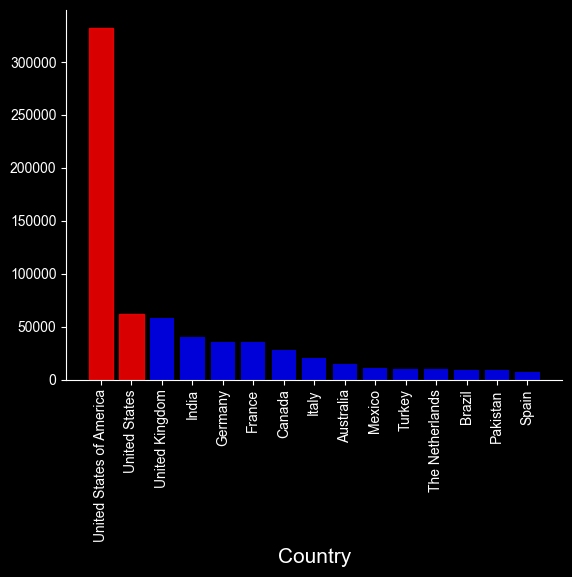

In [6]:
name_check = pd.DataFrame(data = trump_biden_data.groupby('country')['tweet'].count().sort_values(ascending=False).head(15))
name_check = name_check.reset_index()
ax = plt.bar(x = 'country', height = 'tweet', color = 'blue', alpha = 0.85, data = name_check)
ax[0].set_color('red')
ax[1].set_color('red')
plt.xlabel('Country', fontsize = 15)
plt.xticks(rotation=90)
sns.despine()
sns.set_theme(rc = {'xtick.labelsize' : 12.0})
sns.set_style('white')


##### We observe that there are tweets from other countries apart from the US so we further clean the country column and only keep the tweets which are from the US. Moreover, observe that the first two bars both represents tweets from the USA so, we must keep both of them as one country

In [7]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['country'] == "United States") | (trump_biden_data['country'] == "United States of America")] 
trump_biden_data.isna().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                      20
user_id                      0
user_name                    1
user_screen_name             0
user_description         23618
user_join_date               0
user_followers_count         0
user_location                0
lat                          0
long                         0
city                    201791
country                      0
continent                    0
state                    61933
state_code               61933
collected_at                 0
Candidate Name               0
dtype: int64

In [8]:
trump_biden_data = trump_biden_data[(trump_biden_data['state'] != 'Guam')]
trump_biden_data = trump_biden_data[(trump_biden_data['state'] != 'Puerto Rico')]

##### After all the data wrangling we finally check whether if there are any important columns that contains the NaN values so we could remove them as well. Since, state name is an integral part of the research question we remove all the tweets that does not contain the state name. Note that although city and user description have NaN values, we still keep those tweets as they do not hinder our research. 

In [9]:
trump_biden_data = trump_biden_data.dropna(subset = 'state') # we remove the tweets with na values in the state column

##### There can be numerous tweets that can be in both the data sets given that there is a possibilty that tweets may contain both Biden and Trump names. We have to account for the repeated tweets after both the sets were concatenated and remove them

In [10]:
trump_biden_data = trump_biden_data.drop_duplicates(subset = 'tweet', keep = False)

##### Lastly, we must remove all the tweets that were tweeted after the election poll that was held on November 3rd 2020. We would only account tweets that were tweeted prior the actual election to accurately predict the election results

In [11]:
trump_biden_data = trump_biden_data.loc[(trump_biden_data['created_at'] < '2020-11-03 24:00:00')] # only keeps the observations until the day of election which was November 3rd 2020

##### To further progress in the project, identifying sentiment state for each tweet was crucial. For that purpose, the tweet data had to be heavily cleaned because the sentiment analyzer which we will be working with only allows plain text data. Unfortunately, our tweet messages were far from clean and contained a lot of data which was not acceptable to the analyzer. For this purpose regex (regular expressions) was imported to clean each tweet in the combined data set.

##### The following code cleans the tweet messages very carefully and leaves us with a clean and plain textual sentence. We define a function that takes in a string of characters. It then turns every letter into lower case. It then removes all the apostrophes from the string, removes # hashtags in the beginning, middle or at the end of a tweet. Similarly, it removes the @ mentions in a similar way that maybe used inside a tweet. The function then removes any sort of punctuations including commas, question mark and exclamation mark. Furthermore, it removes any mentioned links and websites that starts with 'https'. It then splits all the words into a list to check for stop words from a pre-specified list and remove them respectively from the list. Stop words are words in a sentence that are of no importance and which does not bring any new meaning to the message. Once stop words are removed from the list of words, they are then joined back again as a sentence ready for further analysis.

In [12]:
stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from",
"put", "rather", "said", "same", "ask", "about"] # randomly made a list of some words considered to be unuseful
def clean_tweet(tweet):
    clean = tweet.lower() # lowercasing all the letters in the tweet
    clean = re.sub("'", "", clean) # removing ' from tweets
    clean = re.sub("#[A-Za-z0-9_]+","", clean) # removing hashtags 
    clean = re.sub("@[A-Za-z0-9_]+","", clean) # removing mentions
    clean = re.sub('[()!?]', ' ', clean) # removing punctuations including commas, 
                                       # exclamation marks question marks etc
    clean = re.sub('\[.*?\]',' ', clean) 
    clean = re.sub(r'http\S+', '', clean) # removing any website links
    clean = re.sub("[^a-z0-9]"," ", clean) # removes all non-alphabetic 
                                         #letters and keeps alphabetic and numbers 
    clean = clean.split() # splits the tweet string into a list
    clean = [word for word in clean if not word in stopwords] # comprehension to remove any stopwords from the list
    clean = " ".join(word for word in clean) # joins back all the words from the list as a sentece
    return clean
  

##### We now create a new column in our data set for the cleaned tweet and apply our defined function on every tweet in our data set. 

In [13]:
trump_biden_data['clean'] = trump_biden_data['tweet'].apply(lambda x: clean_tweet(x))  

##### In this project, the use of a lexicon based sentimental analysis is done through VADER (Valence Aware Dictionary and Sentiment Reasoner) which automatically identifies the sentiment of a text based on words and slangs. The function SentimentIntensityAnalyzer is present in the natural language toolkit (NLTK) of python that takes in our cleaned data.

##### We now apply the pre-defined sentiment intensity analyzer function on our cleaned tweets. We created a new column for the polairty score for each tweet. This simply calculates the polarity scores of each tweet between negative, neutral and positive. We then observe the compund score, the addition of all scores of the three categories. If the compound is closer to +1 then the tweet is positive while if it is closer to -1 then it would be considered negative. 

In [14]:
sent_analyzer = SentimentIntensityAnalyzer() # assigning the analyzer to a variable
trump_biden_data['polarity_score'] = trump_biden_data['clean'].apply(lambda x: sent_analyzer.polarity_scores(x))
# creating the sentiment column and using the analyzer on the cleaned tweets to calculate polarity scores

##### The compound score is being categorized between positive, neutral or negative. As mentioned before, a positive compound score will be considered a positive tweet and any compound score that is negative will be considered negative tweet. 

In [15]:
def emotion_state(sentiment_score):
  """
  This function takes in the sentiment score values and identifies what emotion does the score refers to
  between the 3 general states of Positive, Negative and Neutral 
  """
  if sentiment_score['compound'] >= 0.05: # creating a threshold of positive tweets for the polarity scores 
    return "Positive"
  elif sentiment_score['compound'] <= -0.05: # creating a threshold of negative tweets for the polarity scores
    return "Negative"
  else:
    return "Neutral" 


##### This is the most important part of our code to continue our analysis. We pick all the tweets that has a positive sentiment. As mentioned in the introduction we assumed that the all engagement on positive tweets should have a positive relationship with the vote counts of a particular state. 
##### Note that this dataset still contains both the candidates' tweets.

In [16]:
trump_biden_data['Sentiment'] = trump_biden_data['polarity_score'].apply(lambda x: emotion_state(x)) # applying the function and categorozing each tweet in the data set

In [17]:
only_positive = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Positive']
only_negative = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Negative']

##### The following code reads the data from the Election Results Data set. This is the president county data set with the candidate names along with it. After reading the csv file, we only kept the observations with Joe Biden and Donald Trump and remove all other candidates. We then categorized the data set with state and candidate and changed the column name for merging purposes.

In [18]:
results = pd.read_csv(r"C:\Users\danis\Desktop\University of Toronto\Winter 2023\ECO225H1\ECO225Project\data\president_county_candidate.csv")
results = results.loc[(results['candidate'] == "Joe Biden") | (results['candidate'] == 'Donald Trump')]
tvbs = results.groupby(['state', 'candidate']).sum('total_votes')
tvbs = tvbs.reset_index()
tvbs.rename(columns = {'candidate':'Candidate Name'}, inplace = True)


##### We now merge our dataset (tvbs) that contains total votes by state with the data frames with only positive tweets and only negative tweets respectively. We calculated the averages of our independent variables likes likes and retweet counts in those states from the new data frames.  

In [20]:
merge_pos_vote = pd.merge(only_positive, tvbs, on = ['state', 'Candidate Name'])
mean_pos_table = merge_pos_vote.groupby('state').mean()
merge_neg_vote = pd.merge(only_negative, tvbs, on = ['state', 'Candidate Name'])
mean_neg_table = merge_neg_vote.groupby('state').mean()

C:\Users\danis\AppData\Local\Temp\ipykernel_17504\235024837.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_pos_table = merge_pos_vote.groupby('state').mean()
C:\Users\danis\AppData\Local\Temp\ipykernel_17504\235024837.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_neg_table = merge_neg_vote.groupby('state').mean()


## Summary Statistics Tables

##### The following summary statistics table shows detailed information regarding retweets of the tweets that mentions both the election candidates, Joe Biden and Donald Trump. Firstly, note that the number of observations for Biden is much lower than Trump's. Yet, we see that the mean retweet for Joe Biden is higher than Donald Trump. This is because there are more retweets of the tweets with Biden mentioned than Trump. Moreover, the maximum number of retweets on a single tweet relating to Joe Biden is 3 times larger than of the maximum from the tweets which mentions Trump. This significance further shows to be true since the standard deviation of the retweets of Biden is double of that of Trump's meaning that the retweets are more spread out and much far from the mean when compared to Trump's retweet data. This shows high variability of retweet counts in tweets relating to Biden. It is evident through the retweets that Biden's message and campaign is more cirulating and much stornger.

In [21]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].sum()

Candidate Name
Donald Trump    212546.0
Joe Biden       267398.0
Name: retweet_count, dtype: float64

In [22]:
trump_biden_data.groupby('Candidate Name')["retweet_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,2.040670,42.554416,0.0,0.0,0.0,0.0,5986.0
Joe Biden,76632.0,3.489378,85.341246,0.0,0.0,0.0,0.0,17652.0


##### We categorize all the positive tweets between candidate names and now see the number of retweet counts once again. We observe how the number of retweet counts has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 3.48 to 4 when compared to mixed sentiment from earlier. Biden's standard deviation remains high in the only positive tweets as well. Infact it is three times more high than Trump's deviation. Biden's positive tweets are much more impactful in general when compared to Trump's.

In [23]:
only_positive.groupby('Candidate Name')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,2.300664,39.715792,0.0,0.0,0.0,0.0,3243.0
Joe Biden,27118.0,4.041707,119.821023,0.0,0.0,0.0,0.0,17652.0


##### The table below shows the aforementioned information where there is a higher number of tweets of Donald Trump than Joe Biden. Moreover, the total number of likes with Joe Biden tweets is higher than Trump's total likes. This leads to the obvious conclusion that the average number of likes received by Biden tweets is higher than Trump's tweeets as shown in the table. It is quite spectacular to observe that the maximum number of likes on a single tweet of Biden is almost seven times more than any tweet that mentions Trump. This clearly indicates Biden's populairty in general.

In [24]:
trump_biden_data.groupby('Candidate Name')["likes"].sum()

Candidate Name
Donald Trump     777191.0
Joe Biden       1035446.0
Name: likes, dtype: float64

In [25]:
trump_biden_data.groupby('Candidate Name')["likes"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,7.461869,173.643278,0.0,0.0,0.0,1.0,25987.0
Joe Biden,76632.0,13.511927,695.563695,0.0,0.0,0.0,1.0,165702.0


##### We categorize all the positive tweets between candidate names and now see the number of likes once again. We observe how the number of tweets has decreased after extracting only positive tweets. Nevertheless the average number of likes for Joe Biden has increased from 13 to 17 when compared to mixed sentiment. Biden's standard deviation still remains high in the only positive tweets as well. We can also see that the highest number of likes on a Biden tweet is ten times more than of any positive tweet related to trump. This may indicate that Biden's message is more powerful or patriotic on the social media platform.

In [26]:
only_positive.groupby('Candidate Name')['likes'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,8.778190,171.045578,0.0,0.0,0.0,1.0,16154.0
Joe Biden,27118.0,17.696327,1047.403007,0.0,0.0,0.0,2.0,165702.0


##### Note that the total user follower count and number of tweets both for Biden are lower than Trump. Still, people who tweeted about Biden have a higher average following on Twitter than the users who tweeted about Trump. Although user with Trump tweets has a higher number of total followers, there is one speicific user who has the highest follower count that tweeted about Biden that was higher than any person who tweeted about Trump with about 5.7 million followers (FYI: It is Perez Hamilton). It is worth mentioning the interquartile ranges for user followers variable for each candidate. The inter-quartile range (IQR) for trump user follower is 2548 while Biden's IQR is 2869. Biden's higher IQR indicates the higher dispersion of followers count which can also be observed by a higher standard deviation of followers of Biden supporters.

In [27]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].sum()

Candidate Name
Donald Trump    882677497.0
Joe Biden       760937285.0
Name: user_followers_count, dtype: float64

In [28]:
trump_biden_data.groupby('Candidate Name')["user_followers_count"].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,104155.0,8474.653132,81261.428768,0.0,138.0,694.0,2685.0,4163175.0
Joe Biden,76632.0,9929.758913,87360.647876,0.0,143.0,789.0,3020.0,5750841.0


##### Note that the total user follower count and number of tweets both for Biden are lower than the original one with all sentiments and still lower than trump. Nevertheless, people who tweeted about Biden still have a higher mean following on Twitter when compared to Trump. Moreover, Biden's standard deviation remains higher than trump in the number of followers who supports Biden.

In [29]:
only_positive.groupby('Candidate Name')['user_followers_count'].describe()

,count,mean,std,min,25%,50%,75%,max
Candidate Name,,,,,,,,
Donald Trump,34773.0,7485.942283,63969.466534,0.0,136.0,681.0,2594.00,4163175.0
Joe Biden,27118.0,9499.334944,88917.726314,0.0,146.0,782.5,2911.75,5750841.0


## Plots and Figures

##### The following code extracts out the tweets with the highest average number of likes by state name for each candidate. We then compare both the candidates likes wise based on the state with a bar plot.

In [30]:
top20_likes = only_positive.groupby('state')['likes'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_likes = only_positive.groupby(['state', 'Candidate Name'])['likes'].mean().reset_index()
pos_table_likes = pos_table_likes[pos_table_likes['state'].isin(top20_likes)]

##### The code outputs the highest mean number of likes for all positive tweets of the top 20 states by Candidates. We observe that NewYork has the highest number of likes on average for Joe Biden positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia while Trump won in Indiana where he had a higher number of likes on positive tweets 

In [31]:
my_palette = {'Donald Trump': 'red', 'Joe Biden': 'blue'}

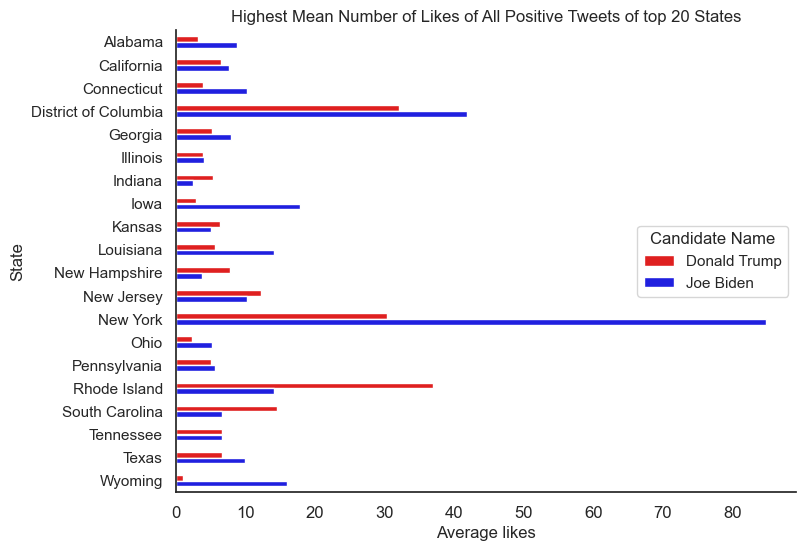

In [32]:
plot_follower = sns.barplot(
    data=pos_table_likes,
    x='likes',
    y='state',
    hue='Candidate Name',
    width=0.5,
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Mean Number of Likes of All Positive Tweets of top 20 States',
    xlabel='Average likes',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

##### The following code extracts out the tweets with the highest number of retweet count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [33]:
top20_retweets = only_positive.groupby('state')['retweet_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_retweets = only_positive.groupby(['state', 'Candidate Name'])['retweet_count'].mean().reset_index()
pos_table_retweets = pos_table_retweets[pos_table_retweets['state'].isin(top20_retweets)]

##### The code outputs the highest average number of retweets for all positive tweets of the top 20 states by Candidates. We observe that NewYork and District of Columbia has the highest number of average retweet counts for Joe Biden's positive tweets. It is not a coincidence as we will see that Joe Biden infact did win in NewYork and the District of Columbia. Similarly, Trump won in South carolina where he had a higher average number of retweet counts on his positive tweets 

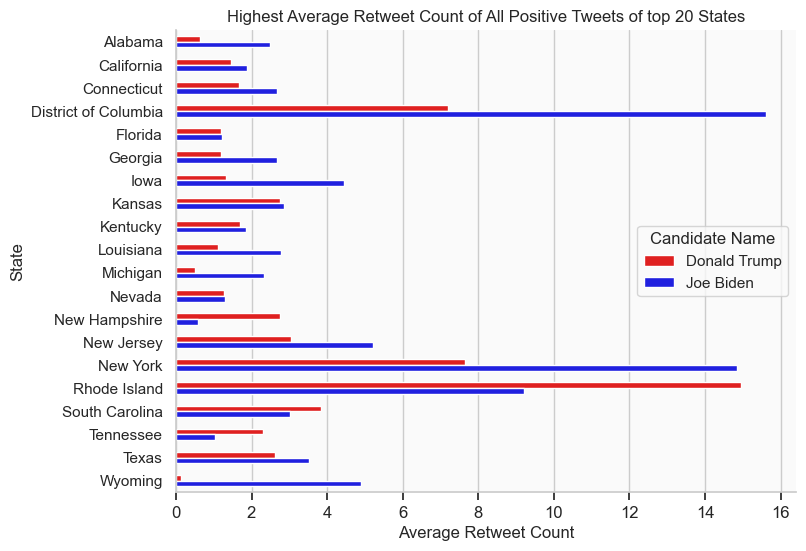

In [34]:

plot_follower = sns.barplot(
    data=pos_table_retweets,
    x='retweet_count',
    y='state',
    hue='Candidate Name',
    width=0.5,
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Average Retweet Count of All Positive Tweets of top 20 States',
    xlabel='Average Retweet Count',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

##### The following code extracts out the tweets with the highest number of user follower count by state name for each candidate. We then compare both the candidates retweet counts wise based on the state with a bar plot.

In [35]:
top20_follower = only_positive.groupby('state')['user_followers_count'].mean().sort_values(ascending = False).head(20).index.tolist()
pos_table_follower = only_positive.groupby(['state', 'Candidate Name'])['user_followers_count'].mean().reset_index()
pos_table_follower = pos_table_follower[pos_table_follower['state'].isin(top20_follower)]

##### We plot the barplot and observe a similar trend particularly regarding NewYork and District of Columbia. However, we see that New Jersey has a lot of user followers with positive tweets yet it was Biden who won the election in New Jersey. Note how there is an average of 40000 twitter user followers for Biden positive tweets in District of Columbia.  

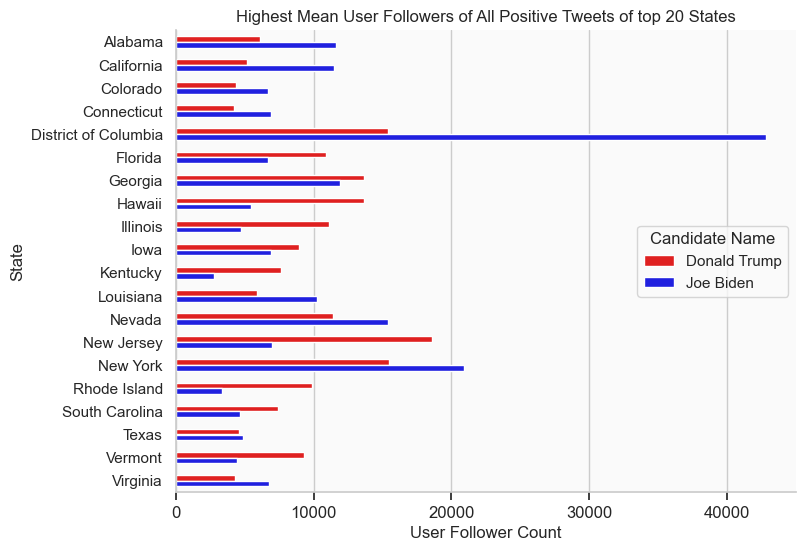

In [36]:
# Set color palette
my_palette = {'Donald Trump': 'red', 'Joe Biden': 'blue'}

plot_follower = sns.barplot(
    data=pos_table_follower,
    x='user_followers_count',
    y='state',
    hue='Candidate Name',
    width=0.5,
    palette=my_palette  
)

# Set title and axis labels
plot_follower.set(
    title='Highest Mean User Followers of All Positive Tweets of top 20 States',
    xlabel='User Follower Count',
    ylabel='State'
)

# Removing spines
sns.despine()

# Move legend to center right
sns.move_legend(plot_follower, 'center right')

# Set figure size and style
plot_follower.figure.set_size_inches(8, 6)
sns.set_style(
    style='whitegrid',
    rc={"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': False}
)

#### Total Votes VS Average Likes by State
##### Notice how we observe a general positive corelation between average likes and total vote counts for most states.  Nevertheless, we can comfortably assert that there is a weak association between both the variables. There are some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom left, there is a cluster which would indicate that both of them are indeed related to each other. The addition of the linear regression line complements the positive relation even more between the average likes and total votes. Note that all dots represent a specific state

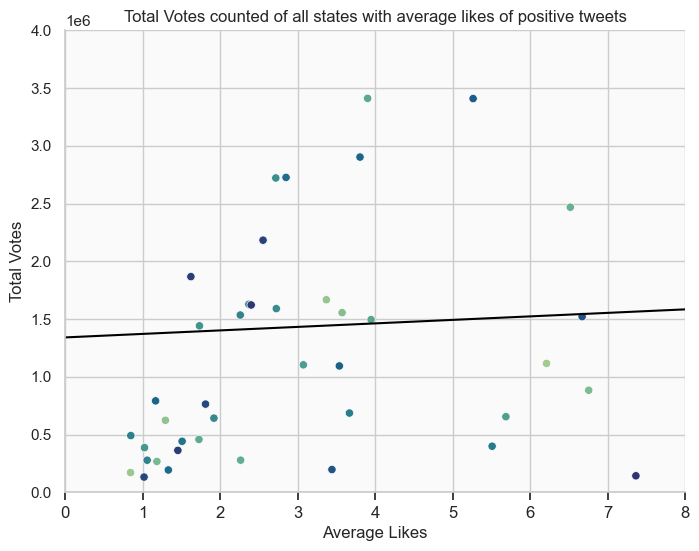

In [37]:
x = mean_pos_table['likes'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_likes = sns.scatterplot(data = mean_pos_table,x = 'likes', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_likes.set(title = 'Total Votes counted of all states with average likes of positive tweets',xlabel= 'Average Likes', ylabel = 'Total Votes', xlim=(0, 8), ylim = (0, 4000000))
lr.fit(x,y)
x = np.linspace(0.0, 8.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_likes.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_likes.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

#### Total Votes vs Average Retweet Count
##### In this scatter plot we can observe a general positive corelation between average retweet counts and total vote counts for most states. Moreover, there is a weak association between both the variables meaning that some states do not follow the general trend strictly. So, there can be some states which can be considered outliers and be removed. Moreover, if we look closely on the bottom half of the plot, there is a cluster which would indicate that both variables are corelated to each other. The linear regression line also depicts the positive relation between the average retweet count and total votes. Note that all dots represent a specific state
 

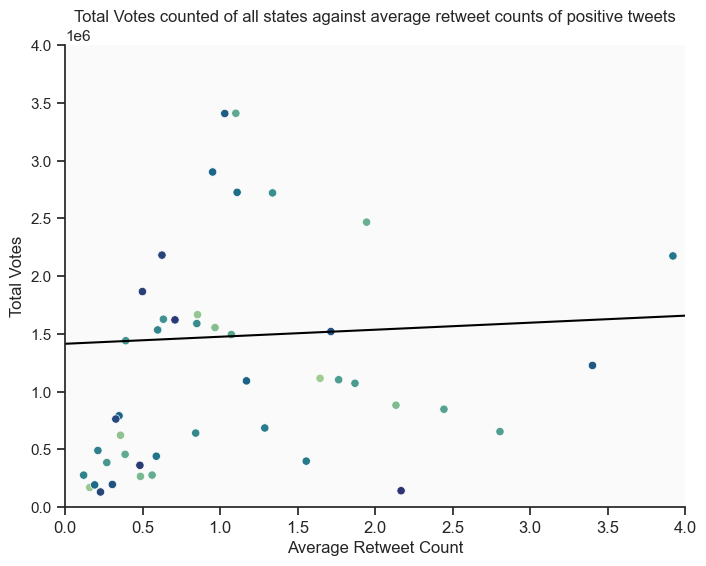

In [38]:
x = mean_pos_table['retweet_count'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_retweet = sns.scatterplot(data = mean_pos_table,x = 'retweet_count', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_retweet.set(title = 'Total Votes counted of all states against average retweet counts of positive tweets', xlabel = 'Average Retweet Count', ylabel = 'Total Votes',xlim=(0, 4), ylim = (0, 4000000))
lr.fit(x,y)
x = np.linspace(0.0, 4.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_retweet.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_retweet.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

#### Total Votes vs Average User Follower
##### Through this plot, we can infer a direct corelation between average user follower count and total vote counts for most states(all dots represent a specific state). Moreover, there is a partially strong association between both the variables if we see the bottom half of the plot. However, some states do not follow the general trend and maybe considered outliers. The linear regression line clearly shows a positive relation between the average user follower count and total votes.

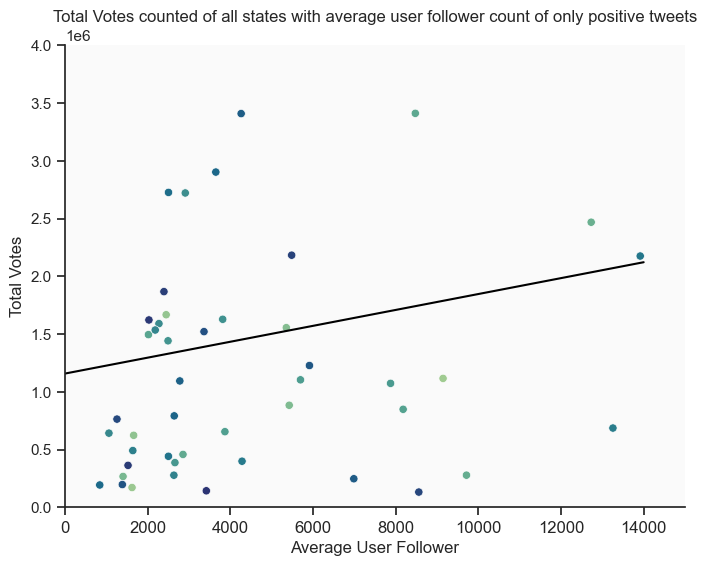

In [39]:
x = mean_pos_table['user_followers_count'].values.reshape(-1,1)
y = mean_pos_table['total_votes'].values.reshape(-1,1)
plot_avg_user = sns.scatterplot(data = mean_pos_table,x = 'user_followers_count', y = 'total_votes', hue = 'state', legend = False, palette='crest')
plot_avg_user.set(title = 'Total Votes counted of all states with average user follower count of only positive tweets', xlabel = 'Average User Follower', ylabel = 'Total Votes', xlim=(0, 15000), ylim = (0,4000000))
lr.fit(x,y)
x = np.linspace(0.0, 14000.0).reshape(-1, 1)
y_pred = lr.predict(x)
plot_avg_user.plot(x, y_pred, color = 'black')
sns.despine()
plot_avg_user.figure.set_size_inches(8, 6)
sns.set_style(style = 'white', rc = {"axes.facecolor": "#FAFAFA", 'xtick.bottom': True, 'ytick.left': True})

## Conclusion
##### The project essentially aimed to demonstrate the relationship between different variables that kept the public enagaged in social media platforms like Twitter and share their opinions in different ways. Some people like tweets while others can retweet it to show their support or interest towards an idea. This activity of liking and retweeting can significantly reflect people's emotions at a certain time or in a certain region. Sentiment Analysis helped identify which states were happy to support Biden or Trump pretty straighforwardly. The Statistics tables indicated on average how much people were interested in the campaign and how many likes and retweet counts was each candidate receiving. Moreover, the comparison of only positive tweets with regular tweets also illustrated the differences in public engagement on such tweets. We could have used the negative sentiment (we would expect the relationship between variables to be the opposite) tweets as well but it would have made the analysis unbalance. 

##### The plots were also a good way to visualize which candidate was provoking more public engagement in certain states. We used the top 20 states with highest averages to check which candidate was winning. Most of the States mentioned in the bar plots, Biden was the one with more engagement on twitter due to high number of likes and retweets. Thus, without a doubt Biden was the final winner. Similarly, the scatter plots demostrated that vote counts and average likes had some sort of weak relation. Moreover, there were clusters in both the average likes and avergae retweet count plots showing that both variables moved together.

# Project 2

## The Message

##### The project is based upon the question over how the public engagement on Twitter is quantified towards political parties to predict election results through Sentiment Analysis of the tweets present in our data sets. Continuing my previously used independent variables (average number of likes, user follower count and retweet count of the tweets) from Project 1, I will move forward to demonstrate over how those variables have the relationship with the total number of votes recieved by each candidate. 

##### The second project aims to distinguish the relationship between the average retweet counts, likes and follower counts with the votes recieved by each candidate. Althought we did observed the positive relationships between the variables with only the positive tweets previously, we will now see the difference between how strong association and relationship between the variables are for each candidate for the tweets of a candidate regardless of the sentiment. In particular, the idea is if the relationship between variables are stronger for a specific candidate, it would reflect on the public engagement in a state and eventually the final results of the election. The concept is slightly counter-intuitive as we will see in the upcoming figures. Since, the data set we have has more significantly more tweets for Biden than Trump.

##### Moreover the maps aim to show how we can observe the distribution of the positive and negative emotions in each state for each candidate. The maps can become a good predictor over which candidate won in a state which depends on whether that state corresponds to stronger or weaker sentiment (positive or negative in our case). We observe in our study that not only a high positivity score but a low negativity score can also become a good predictor over who wins in some states specially if they are the battle ground states demonstrating high competition among the candidates. 

##### The following code creates a data frame that contains the average number of likes of the positive and negative sentiment tweets of Trump and Biden of each state. The data frame categorized the tweets with sentiment of each candidate and the calculated the average number of likes for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump. 

In [40]:
only_negative = trump_biden_data.loc[trump_biden_data['Sentiment'] == 'Negative']
pos_neg_only = trump_biden_data.loc[trump_biden_data['Sentiment'] != 'Neutral']

all_state_likes = pos_neg_only.groupby(['state'])['likes'].mean().sort_values(ascending = False).index.tolist()
pos_neg_likes = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['likes'].mean().reset_index()
pos_neg_likes = pos_neg_likes[pos_neg_likes['state'].isin(all_state_likes)]

pos_neg_vote_likes = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_likes = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['likes'].mean().reset_index()
pos_neg_vote_likes = pos_neg_vote_likes[pos_neg_vote_likes['state'].isin(all_state_likes)]

pos_neg_likes_sent = pd.merge(tvbs,pos_neg_vote_likes, on = ['state','Candidate Name'])

##### The following code removes the outlier states which were too high and made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trumo and Biden which will be used to plot oour graphs. The plots shows the relationship between the average number of likes and vote count. Each dot in the scatter plots represent a state in the United States. 

##### Note here we observe that in the Trump graph, average likes and total votes has a stronger relationship which can be seen through the regression line when compared to the Biden graph which has a weaker association. The regression line explains a slighlty counter-intuitve idea. Since, Trump tweets in most states recieved average likes under 10, there is a cluster in the lower left corner for him. There are quite a few states that had a high average number of likes for Biden Tweets which made the regression line more flatter for him. This is clearly because Biden's tweets has more enagegement on his tweets. Thus in our model, the weaker the association the more the engagement!

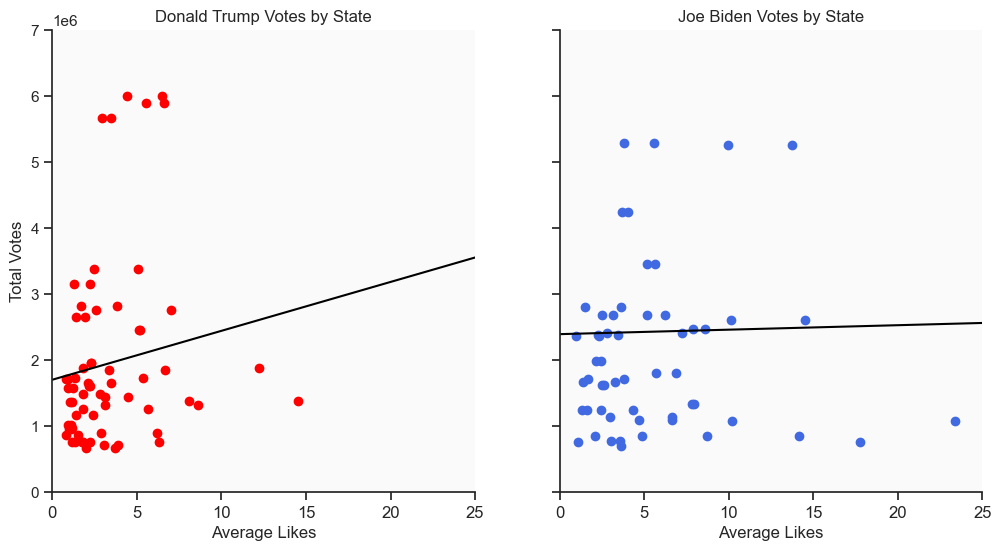

In [41]:
import numpy as np
from scipy.stats import linregress

trump_likes_only = pos_neg_likes_sent[pos_neg_likes_sent['Candidate Name'] == 'Donald Trump']
trump_likes_only = trump_likes_only.loc[trump_likes_only['likes'] < 40]
trump_likes_only = trump_likes_only.loc[trump_likes_only['total_votes'] > 650000]
biden_likes_only = pos_neg_likes_sent[pos_neg_likes_sent['Candidate Name'] == 'Joe Biden']
biden_likes_only = biden_likes_only.loc[biden_likes_only['likes'] < 40]
biden_likes_only = biden_likes_only.loc[biden_likes_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_likes_only['likes'], trump_likes_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Votes by State', xlabel = 'Average Likes', ylabel = 'Total Votes')
axs[0].set(xlim = (0,25), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_likes_only['likes'], trump_likes_only['total_votes'])
x = np.array([0, 25])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_likes_only['likes'], biden_likes_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Votes by State', xlabel = 'Average Likes')
axs[1].set(xlim = (0,25))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_likes_only['likes'], biden_likes_only['total_votes'])
x = np.array([0, 25])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

##### The following code creates a data frame that contains the average number of retweets of the positive and negative sentiment tweets of Trump and Biden of each state. The data frame categorized the tweets with sentiment of each candidate and the calculated the average number of retweets for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump. 

In [42]:
all_state_retweet = pos_neg_only.groupby(['state'])['retweet_count'].mean().sort_values(ascending = False).index.tolist()
pos_neg_retweet = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['retweet_count'].mean().reset_index()
pos_neg_retweet = pos_neg_retweet[pos_neg_retweet['state'].isin(all_state_retweet)]

In [43]:
pos_neg_vote_retweet = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_retweet = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['retweet_count'].mean().reset_index()
pos_neg_vote_retweet = pos_neg_vote_retweet[pos_neg_vote_retweet['state'].isin(all_state_retweet)]

In [44]:
pos_neg_retweet_sent = pd.merge(tvbs,pos_neg_vote_retweet, on = ['state','Candidate Name'])

##### The following code removes the outlier states which contained high average retweet counts that made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trumo and Biden which will be used to plot oour graphs. The plots shows the relationship between the average number of retweets and vote count in each state. Each dot in the scatter plots represent a state in the United States. 

##### Note here we observe that in the Trump graph, average retweet and total votes has a stronger association which can be observed by the regression line as compared to the Biden graph which has a weaker relationship. The regression line explains a slighlty counter-intuitve idea. Since, Trump tweets in most states recieved average retweets under 4, there is a cluster in the lower left corner for him. There are quite a few states that had a high average number of retweets of which many are much higher than 4 for Biden Tweets which made the regression line more flatter for him. This is clearly because Biden's tweets has more enagegement on his tweets through higher number of retweets per tweet. This is another example of how a weaker association corelates higher engagement. 

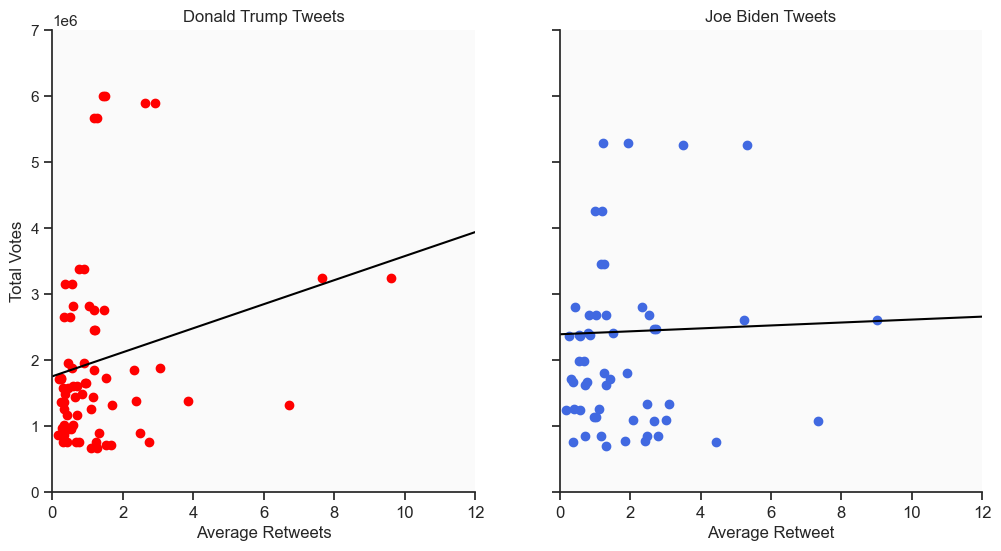

In [45]:
import numpy as np
from scipy.stats import linregress

trump_retweet_only = pos_neg_retweet_sent[pos_neg_retweet_sent['Candidate Name'] == 'Donald Trump']
trump_retweet_only = trump_retweet_only.loc[trump_retweet_only['retweet_count'] < 10]
trump_retweet_only = trump_retweet_only.loc[trump_retweet_only['total_votes'] > 650000]
biden_retweet_only = pos_neg_retweet_sent[pos_neg_retweet_sent['Candidate Name'] == 'Joe Biden']
biden_retweet_only = biden_retweet_only.loc[biden_retweet_only['retweet_count'] < 10]
biden_retweet_only = biden_retweet_only.loc[biden_retweet_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_retweet_only['retweet_count'], trump_retweet_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Tweets', xlabel = 'Average Retweets', ylabel = 'Total Votes')
axs[0].set(xlim = (0,12), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_retweet_only['retweet_count'], trump_retweet_only['total_votes'])
x = np.array([0, 16])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_retweet_only['retweet_count'], biden_retweet_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Tweets', xlabel = 'Average Retweet')
axs[1].set(xlim = (0,12))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_retweet_only['retweet_count'], biden_retweet_only['total_votes'])
x = np.array([0, 16])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

##### The following code creates a data frame that contains the user followers that tweeted about Biden and Trump. The data frame is categorized with the sentiment by each state for each candidate. We then calculated the average number of user follower for each state. This data frame will then be used to create the individual scatter plots for Biden and Trump.

In [46]:
all_state_follower = pos_neg_only.groupby(['state'])['user_followers_count'].mean().sort_values(ascending = False).index.tolist()
pos_neg_follower = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['user_followers_count'].mean().reset_index()
pos_neg_follower = pos_neg_follower[pos_neg_follower['state'].isin(all_state_follower)]

In [47]:
pos_neg_vote_follower = pd.merge(pos_neg_only, tvbs, on = ['state', 'Candidate Name'])
pos_neg_vote_follower = pos_neg_only.groupby(['state', 'Candidate Name', 'Sentiment'])['user_followers_count'].mean().reset_index()
pos_neg_vote_follower = pos_neg_vote_follower[pos_neg_vote_follower['state'].isin(all_state_follower)]

In [48]:
pos_neg_follower_sent = pd.merge(tvbs,pos_neg_vote_follower, on = ['state','Candidate Name'])

##### The following code removes the outlier states which contained high average user follower counts that made the relationship between the variables skewed. Moreover we made two separate data frames for our candidates Trump and Biden which will be used to plot our graphs. The plots shows the relationship between the average number of user followers and vote count in each state. Each dot in the scatter plots represent a specific state in the United States. 

##### Just like in other graphs, we observe here too that in the Trump graph, average user followers and total votes has a stronger association which can be observed by the regression line as compared to the Biden graph which has a weaker relationship. This is another example of how the weaker association asserts more public engagement. Simiarly, Trump has a more dense cluster in the lower left corner of the first plot thna compared to Biden. This is because Biden has tweets that were tweeted by users with higher follower counts on average in more states than Trump. Thus, Biden's regression line also depicts weaker asscociation between the total votes and user follower count. This is another example of higher public engagement with weaker association. 

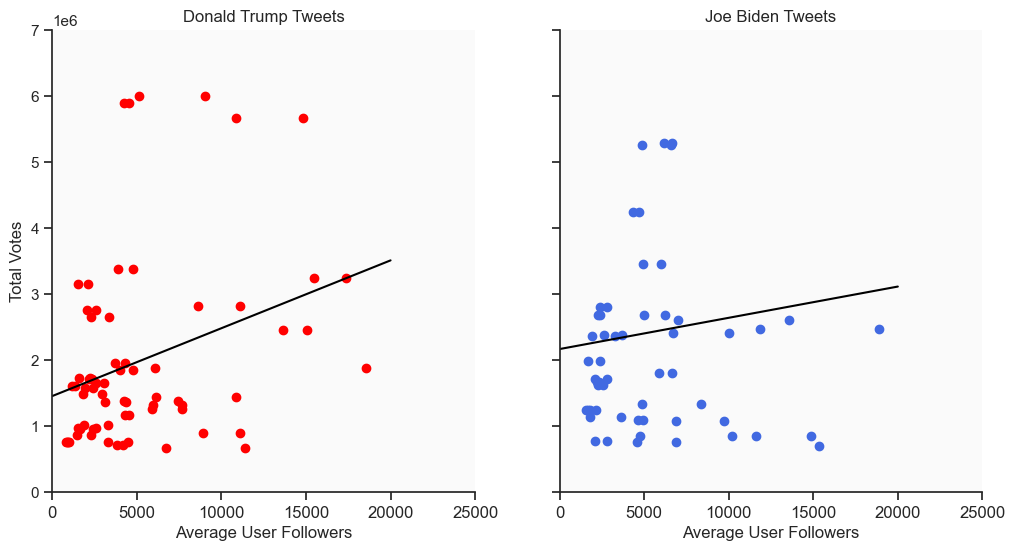

In [49]:
import numpy as np
from scipy.stats import linregress

trump_follower_only = pos_neg_follower_sent[pos_neg_follower_sent['Candidate Name'] == 'Donald Trump']
trump_follower_only = trump_follower_only.loc[trump_follower_only['user_followers_count'] < 20000]
trump_follower_only = trump_follower_only.loc[trump_follower_only['total_votes'] > 650000]
biden_follower_only = pos_neg_follower_sent[pos_neg_follower_sent['Candidate Name'] == 'Joe Biden']
biden_follower_only = biden_follower_only.loc[biden_follower_only['user_followers_count'] < 20000]
biden_follower_only = biden_follower_only.loc[biden_follower_only['total_votes'] > 650000]

# create two subplots side-by-side for Trump and Biden 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey = True)

# plot the positive sentiment scatter plot in the first subplot
axs[0].scatter(trump_follower_only['user_followers_count'], trump_follower_only['total_votes'], color='red')
axs[0].set(title = 'Donald Trump Tweets', xlabel = 'Average User Followers', ylabel = 'Total Votes')
axs[0].set(xlim = (0,25000), ylim = (0,7000000))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# calculate and plot the regression line for positive sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(trump_follower_only['user_followers_count'], trump_follower_only['total_votes'])
x = np.array([0, 20000])
y = intercept + slope * x
axs[0].plot(x, y, color='black')

# plot the negative sentiment scatter plot in the second subplot
axs[1].scatter(biden_follower_only['user_followers_count'], biden_follower_only['total_votes'], color='royalblue')
axs[1].set(title = 'Joe Biden Tweets', xlabel = 'Average User Followers')
axs[1].set(xlim = (0,25000))
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# calculate and plot the regression line for negative sentiment
slope, intercept, rvalue, pvalue, stderr = linregress(biden_follower_only['user_followers_count'], biden_follower_only['total_votes'])
x = np.array([0, 20000])
y = intercept + slope * x
axs[1].plot(x, y, color='black')

plt.show()

##### We convert the polarity score column into a dictionary so we can further separate the tweets between positive and negative tweets

In [50]:
only_positive['polarity_score'].convert_dtypes(dict)
only_negative['polarity_score'].convert_dtypes(dict)

5         {'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou...
19        {'neg': 0.504, 'neu': 0.496, 'pos': 0.0, 'comp...
25        {'neg': 0.127, 'neu': 0.873, 'pos': 0.0, 'comp...
29        {'neg': 0.206, 'neu': 0.712, 'pos': 0.082, 'co...
35        {'neg': 0.643, 'neu': 0.175, 'pos': 0.181, 'co...
                                ...                        
352502    {'neg': 0.661, 'neu': 0.339, 'pos': 0.0, 'comp...
352522    {'neg': 0.385, 'neu': 0.33, 'pos': 0.286, 'com...
352541    {'neg': 0.102, 'neu': 0.844, 'pos': 0.054, 'co...
352568    {'neg': 0.173, 'neu': 0.737, 'pos': 0.09, 'com...
352581    {'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'comp...
Name: polarity_score, Length: 59674, dtype: object

## Maps and Interpretations

##### The aim of the research is to quanitify public engagement on Twitter and predict election results. The maps essentially use the polarity scores as an independent variable and see how the mean positive and negative scores get distributed throughout all the states in the US.
##### The maps in this research below aims to clearly indicate how a high positivity score for each candidate in a state can predict if they would win in the particular state or not. Moreover, we should not only restrict ourselves with the positive score for each candidate, we also account for the negative tweets and their negativity scores for each candidate. The negativity scores can also indicate where a candidate would win or lose depending on how strong the negative sentiment they recieved in a state on Twitter. For example, a strong negative sentiment would indicate that the candidate should have lost in the said state. 

##### The following code creates a data frame that contains the only positive tweets that was created in Project 1. We now add another column in this new data frame which contains the positivity score (referred to as polarity score before) for each tweet. Note that we already calculated these scores from our Sentiment Analyzer previously and we are no extracting them out for mapping. Moreover, we keep all the observations from the United States only. Remember that this data set still contains both the Candidate positive tweets which will soon categorize.

In [52]:
state_op = only_positive[only_positive['country'] == 'United States of America'].dropna(subset=['state_code'])
state_op['positive'] = state_op.polarity_score.apply(lambda x: x.get('compound'))

##### We do a similar procedure for the negativity scores. We use the data frame that contains only the negative tweets of both the candidates and extract out the negative score for each tweet. We make a new column and assign the negativity score to each tweet which was calculated by our sentiment analyzer.

In [53]:
state_on = only_negative[only_negative['country'] == 'United States of America'].dropna(subset = ['state_code'])
state_on['negative'] = state_on.polarity_score.apply(lambda x: x.get('compound'))

##### This is the most important part of the project. We now separate our negative and positive tweets by each candidate. We want to observe the mean distribution scores for the positive and negative sentiments separately for Biden and Trump throughout all the states.  

In [54]:
state_opt = state_op.loc[state_op['Candidate Name'] == 'Donald Trump']
state_opb = state_op.loc[state_op['Candidate Name'] == 'Joe Biden']

state_ont = state_on.loc[state_on['Candidate Name'] == 'Donald Trump']
state_onb = state_on.loc[state_on['Candidate Name'] == 'Joe Biden']

## Merging with the 2020 Election Results Data Set

##### The following code creates a new data frame with the state name and the candidate who won in that particular state. The data frame was created by using the president county data from the election results data set. (This will later be used for mapping in Project 2)

In [ ]:
first_two_rows_by_state = tvbs.groupby('state').head()

# Loop over the unique states in the first two rows and create a new data frame for each state
def vic(df):
    state_dfs = []
    for state in first_two_rows_by_state['state'].unique():
        # Get the vote counts for the two candidates in the current state
        state_rows = first_two_rows_by_state[first_two_rows_by_state['state'] == state]
        candidate_1_votes = state_rows.iloc[0,2]
        candidate_2_votes = state_rows.iloc[1,2]
        
        # Determine which candidate won the state
        if (candidate_1_votes > candidate_2_votes).all():
            winner = 'Donald Trump'
        else:
            winner = 'Joe Biden'
        
        # Create a new data frame for the current state with a single row containing the winner's name
        state_df = pd.DataFrame({'State': [state], 'Winner': [winner]})
        state_dfs.append(state_df)
        
    # Concatenate the state data frames into a single data frame
    result_df = pd.concat(state_dfs, ignore_index=True)
    return result_df
winner = vic(tvbs)

In [56]:
# tvbs.rename(columns = {'candidate':'Candidate Name'}, inplace = True)
winner.rename(columns = {'State' : 'state'}, inplace = True)
winner

,state,Winner
0,Alabama,Donald Trump
1,Alaska,Donald Trump
2,Arizona,Joe Biden
3,Arkansas,Donald Trump
4,California,Joe Biden
5,Colorado,Joe Biden
6,Connecticut,Joe Biden
7,Delaware,Joe Biden
8,District of Columbia,Joe Biden
9,Florida,Donald Trump


In [62]:
import plotly.express as px
color_map = {'Donald Trump': 'red', 'Joe Biden': 'royalblue'}
fig = px.choropleth(winner, 
                    locationmode='USA-states',
                    locations='state_code',
                    color='Winner',
                    scope='usa'
                    color_discrete_map=color_map)
  
fig.show()